#  Hyperparameter Tuning
 
The creation, engineering and preprocessing of  statistical features, the selection of the suitable ones and finally the parametrization of the algorithm are
the main domains, where a user typically adjusts a machine learning system in order to make it succesful.  
It therefore makes sense to search for optimal values automatically. This is often referred to as "hyperparameter tuning". 

The standard approaches that have been around for a long time are a brute force approach doing grid search over the parameter space.
This has been reported to be inferior to a random search strategy in the paper by Bergstra et al.. 

Often more sophisticated approaches arrive at good parameter setting more quickly.
Among these are Bayesian Optimization teqniques, or Kanter et. al.'s  Gaussian Copula Process (GCP), or Tree of Parzen Estimators as in hyperopt


There exist various packages for this optimization. Examples:


| Name          | Author(s)        |       |
| ---------------------------------------------------------- |:-------------:| -----:|
| [Spearmint](https://github.com/JasperSnoek/spearmint)      | JasperSnoek   |   Python    |
| [hyperopt](http://hyperopt.github.io/hyperopt/)             | James Bergstra et. al. | Python |
| [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn) | James Bergstra et. al| Python |
| [REMBO](https://github.com/ziyuw/rembo) | Ziyu Wang | Matlab |
| [MOE](https://github.com/Yelp/MOE) | Eric Liu | C++/Python |
| [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/) | Hutter et al., 2011 | Java |





## Package Selection Criteria

The aim here is to generate a simple worked example.


### Selection Criteria
* Native python in order to be able to study code demontrating the math quickly
* Package allows to specify custom objective functions
* API is transparently exposed to the user and allows to study code using a debugger
* Facilitate porting to different infrastructure

Notes
* Spearmint : Lots of code for spawning child processes involved. This makes it hard to use 
* hyperopt-sklearn: Taylored to scikit-learn and its off-the-shelf classifiers and regressors. Does not allow customizable objective functions
* REMBO: esoteric algorithm, currently Python is preferred. Still a good source for studying Bayes Optimization
* MOE is interesting and very suitable, but as they state in their README, *flow is currently broken* 
* Hyperopt: Their Tree of Parzen Estomators algorithm has some drawbacks with parameter correlations in high dimensional spaces, see [here](http://fastml.com/optimizing-hyperparams-with-hyperopt/)

Despite these problems, I will use hyperopt on a toy example that mimics *Deep Feature Synthesis* using a Random Forest Estimator.  


In [1]:
# data preparation

import math
import csv
import os
import sys

from time import time
from hyperopt import hp, fmin, tpe
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestClassifier

from munge import * # utils for reading data 

def RMSE( y, p ):
	return math.sqrt( MSE( y, p ))

train,test,myid = getdataXGBoostStyle(dropMedhist1=False,BMI_Age=True,SumMedicalKeywords=True)
output_file = 'hyperopt_log.csv'



Creating dataset...
Load the data using pandas
Eliminate missing values


## Parameter Space  and objective function


In [2]:
# Parameter Space
# Parameters copied from Kanter paper, restricting to RandomForest Parameters
space = (
    #hp.choice( "criterion", ["gini","entropy"]),
    hp.uniform("n_estimators", 50,500), #
    hp.uniform("max_depth", 1,20), #  The maximum depth of the decision trees
    hp.uniform("max_features", 1, 100 ) # float if percentage
    #hp.uniform( 'alpha', 0, 1 )
)

In [3]:
def run_wrapper( params ):
    """
    packaging numerical code in run_test
    http://fastml.com/optimizing-hyperparams-with-hyperopt/    
    """
    global run_counter
    global o_f
    
    run_counter += 1
    print ("Iteration number: ", run_counter)
    
    s = time()
    rmse = run_test( params )
    
    print ()
    print ("RMSE:", rmse)
    print ("elapsed: {}s \n".format( int( round( time() - s ))))

    writer.writerow( [ rmse ] + list( params ))
    o_f.flush()
    return rmse
	
def run_test( params ):
    n_estimators, max_depth, max_features = params
    n_estimators = int( n_estimators )
    max_depth = int( max_depth )
    max_features = int( max_features )
    
    print ("max_features:", max_features)
    print ("n_estimators:", n_estimators)
    print ("max_depth:", max_depth)
    rf = RandomForestClassifier(n_jobs=3,max_features=max_features, n_estimators=n_estimators,max_depth=max_depth)
    rf.fit( train.drop(['Response'], axis=1), train['Response']) 
    test_preds  = rf.predict( test.drop(['Response'], axis=1) )
    train_preds  = rf.predict( train.drop(['Response'], axis=1) )
      
    # ordiinal regression specific tuning
    # train_preds = np.clip(train_preds, -0.99, 8.99)
    # test_preds = np.clip(test_preds, -0.99, 8.99)

    # TODO: maybe maximized kappa instead of minimize RMSE
    rmse = RMSE( test['Response'], test_preds )
    return rmse

print ("done")

done


## Run Simulation

In [4]:


max_evals = 10
run_counter = 0

headers = [ 'rmse', "n_estimators","max_depth", 'max_features']


#o_f = open( output_file, 'wb' )

if sys.version_info >= (3,0,0):
    o_f = open(output_file, 'w', newline='')
else:
    o_f = open(output_file, 'wb')

writer = csv.writer( o_f )
writer.writerow( headers )

start_time = time()

#the objective function to minimize
#the space over which to search
#the database in which to store all the point evaluations of the search
#the search algorithm to use

best = fmin( run_wrapper, space, algo = tpe.suggest, max_evals = max_evals )
end_time = time()

print ("Seconds passed:", int( round( end_time - start_time )))
print (best)

Iteration number:  1
max_features: 3
n_estimators: 441
max_depth: 18

RMSE: 7.980611466086317
elapsed: 15s 

Iteration number:  2
max_features: 78
n_estimators: 323
max_depth: 15

RMSE: 7.7169310310722175
elapsed: 78s 

Iteration number:  3
max_features: 38
n_estimators: 168
max_depth: 11

RMSE: 7.762213636347659
elapsed: 17s 

Iteration number:  4
max_features: 36
n_estimators: 164
max_depth: 6

RMSE: 7.867319294162178
elapsed: 11s 

Iteration number:  5
max_features: 10
n_estimators: 386
max_depth: 19

RMSE: 7.712202492846341
elapsed: 26s 

Iteration number:  6
max_features: 27
n_estimators: 307
max_depth: 18

RMSE: 7.70098932145853
elapsed: 41s 

Iteration number:  7
max_features: 49
n_estimators: 168
max_depth: 15

RMSE: 7.722855648500038
elapsed: 34s 

Iteration number:  8
max_features: 28
n_estimators: 335
max_depth: 5

RMSE: 7.965083173580433
elapsed: 14s 

Iteration number:  9
max_features: 85
n_estimators: 59
max_depth: 10

RMSE: 7.761972464805364
elapsed: 13s 

Iteration numb

## Plot RMSE
As mentioned before, hyperopt uses a more sophisticated search strategy. 
So we are not expecting a decreasing trend in the rmse measure over iterations! 

Index(['rmse', 'n_estimators', 'max_depth', 'max_features'], dtype='object')


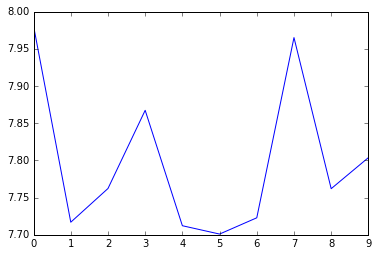

In [20]:
# plot RMSE results
import pandas as pd
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

data=pd.read_csv('hyperopt_log.csv',sep=',',na_values=[" "])
print(data.columns)
data['rmse'].plot(kind='line')

# Summary and

## Comments on Kanter et. al

* Die Vorteile des Kantor Ansatzes mit Gaussian Copula process wird nicht theoretisch belegt oder empirisch ausgearbeitet. Die Vorteile werden nicht klar, und für ein end to end system kann im Prinzip jeder Ansatz hergenommen werden. Also der von beispielsweise hyperopt oder GP oder gar brute force wie random search. 



### Minor Comments
* According to Snoek et al, the approach depends on the type of *function*. They describe the Bayesian optimization process for continuous functions:

"For continuous functions, Bayesian optimization typically works by assuming the unknown function was sampled from a Gaussian process and maintains a posterior distribution for this function as observations are made or, in our case, as the results of running learning algorithm experiments with different hyperparameters are observed. To pick the hyperparameters of the next experiment, one can optimize the ()..."

* Currently the Deep Synthesis Machine *refines itself to continuous*, especially  int-type data. This contrasts with other packages like hyperopt, where the package has functon for recommending the right *algo*.


